### Generating 60,000 (6e4) models for 0-5 Av

In [1]:
# histogram for each imf type of break strength vs number density for each A_v (dust=(0-5))
# Find each of the highest break strength spectra and plot those against the cliff
# read fsps documetnation for changing the imf

In [2]:
def getModel(mass=None, zred=None, logzsol=None, tage=None, dust2=None, imf_type=2, **extras):
    """Build a prospect.models.SpecModel object

    :param mass: (optional, default:None)
        If given, produce spectra for this mass. Otherwise the mass will
        be 1e10 solar masses.

    :param zred: (optional, default: None)
        If given, produce spectra and observed frame photometry appropriate
        for this redshift. Otherwise the redshift will be zero.

    :param logzsol: (optional, default: None)
        If given, fix the model metallicity (:math: `log(Z/Z_sun)`) to the given value.
        Otherwise the metallicity will be set to -0.5.
        
    :param tage: (optional, default: None)
        If given, produce spectra and model photometry appropriate for
        this galactic age. Otherwise the age will be set to 13. Gyrs.

    :param dust2: (optional, default: None)
        If given, produce spectra that are appropriate for provided dust
        attenuation. Otherwise attenuation will be set to 0.6.

    :returns model:
        An instance of prospect.models.SedModel
    """
    from prospect.models import SpecModel
    from prospect.models.templates import TemplateLibrary

    model_params = TemplateLibrary['ssp']

    # Change `isfree` so that all parameters that will be kept track of are identified 
    # in the `model` object as `free_params`
    model_params['zred']['isfree'] = True

    if zred is None:
        model_params['zred']['init'] = 0.0
    else:
        model_params['zred']['init'] = zred

    if mass is not None:
        model_params['mass']['init'] = mass

    if logzsol is not None:
        model_params['logzsol']['init'] = logzsol

    if tage is None:
        model_params['tage']['init'] = 13.
    else:
        model_params['tage']['init'] = tage

    if dust2 is not None:
        model_params['dust2']['init'] = dust2

    model_params['imf_type']['init'] = imf_type

    model = SpecModel(model_params)

    return model

In [1]:
from matplotlib.pyplot import *
import numpy as np
from prospectFunctions import getObs, getWave, getParams, getModel, getSps
import itertools
import astropy.units as u
import astropy.constants as const
import time
from tqdm import tqdm

### Initialize the imf_type

In [ ]:
imf_type = 4

imf_types = ['Salpeter (1955)', 'Chabrier (2003)', 'Kroupa (2001)', 'van Dokkum (2008)', 'Dave (2008)']

grid_ranges, run_params = getParams(imf_type=imf_type, len_logz=100, len_dust=6, len_tage=100, dust=True)
a = 1.0 + run_params['zred']

logzs = grid_ranges['logzsol']
dusts = grid_ranges['dust2']
tages = grid_ranges['tage']

num_models = len(logzs)*len(dusts)*len(tages)

obs = getObs(**run_params)
sps = getSps(**run_params)
wspec, wphot = getWave(obs=obs, sps=sps, **run_params)

In [2]:
data_grid_params = np.empty([len(logzs),len(dusts),len(tages),5])
data_grid_spec = np.empty([len(logzs),len(dusts),len(tages),len(wspec)])

In [3]:
for i_logz,i_dust,i_tage in tqdm(itertools.product(range(len(logzs)),range(len(dusts)),range(len(tages)))):
    
    logz = grid_ranges['logzsol'][i_logz]
    dust = grid_ranges['dust2'][i_dust]
    tage = grid_ranges['tage'][i_tage]

    run_params['tage'] = tage
    run_params['dust2'] = dust
    run_params['logzsol'] = logz

    model = getModel(**run_params)
    
    init_spec, init_phot, init_mfrac = model.predict(model.theta, obs=obs, sps=sps)

    data_grid_params[i_logz, i_dust, i_tage, :] = [run_params['zred'], run_params['mass'], logz, dust, tage]
    data_grid_spec[i_logz, i_dust, i_tage, :] = init_spec

60000it [08:58, 111.38it/s]


In [4]:
model

# from prospect.models.templates import TemplateLibrary
# TemplateLibrary['ssp']

:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  zred: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=4.0)
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  sfh: [0] 
  imf_type: [4] 
  dust_type: [0] 

In [5]:
# np.save(f'params_imf_{imf_type}_{num_models}.npy', data_grid_params)
# np.save(f'specs_imf_{imf_type}_{num_models}.npy', data_grid_spec)

In [18]:
# data_grid_params = np.load(f'params_imf_{imf_type}_60000.npy')
# data_grid_spec = np.load(f'specs_imf_{imf_type}_60000.npy')
# data_grid_breaks_Anna = np.load(f'breaks_Anna_imf_{imf_type}_60000.npy')
# data_grid_breaks_D4000 = np.load(f'breaks_D4000_imf_{imf_type}_60000.npy')

In [6]:
from prospectFunctions import getBreakBounds
break_strengths = {}

starts = np.linspace(3620, 3850, 2, dtype=int)

for start in starts:
    
    bounds = getBreakBounds(wspec, start, **run_params)
    
    blue_lower, blue_upper = bounds['blue'][0], bounds['blue'][1]
    red_lower, red_upper = bounds['red'][0], bounds['red'][1]
    
    data_grid_break = np.empty((len(logzs),len(dusts),len(tages),1))
    
    for i_logz,i_dust,i_tage in itertools.product(range(len(logzs)),range(len(dusts)),range(len(tages))):
        lower = data_grid_spec[i_logz,i_dust,i_tage,blue_lower:blue_upper].mean()
        upper = data_grid_spec[i_logz,i_dust,i_tage,red_lower:red_upper].mean()
    
        ratio = upper/lower
    
        data_grid_break[i_logz,i_dust,i_tage,:] = ratio
    
    break_strengths[f'data_grid_break_{start}'] = data_grid_break

In [7]:
np.save(f'breaks_Anna_imf_{imf_type}_{num_models}.npy', break_strengths['data_grid_break_3620'])
np.save(f'breaks_D4000_imf_{imf_type}_{num_models}.npy', break_strengths['data_grid_break_3850'])

data_grid_breaks_Anna = np.load(f'breaks_Anna_imf_{imf_type}_{num_models}.npy')
data_grid_breaks_D4000 = np.load(f'breaks_D4000_imf_{imf_type}_{num_models}.npy')

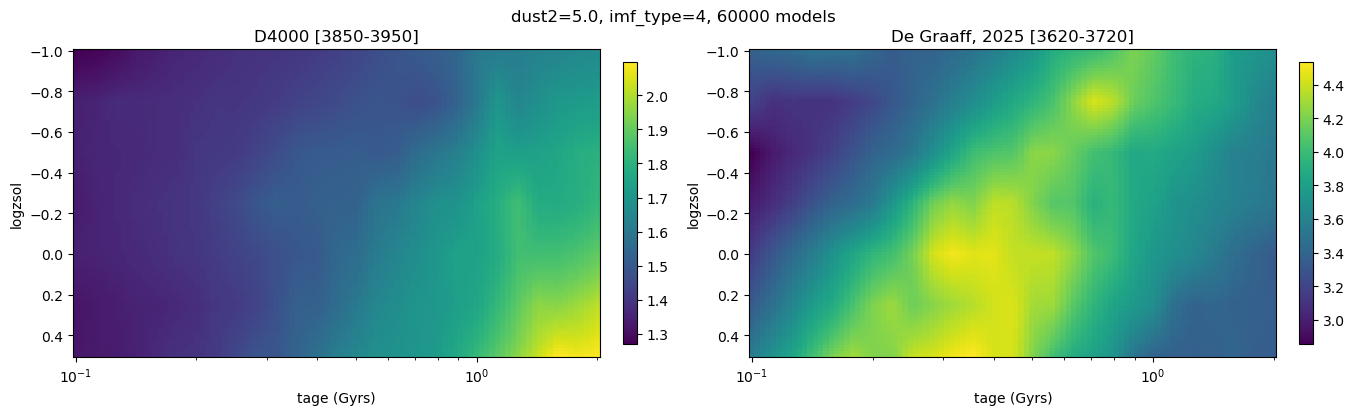

In [8]:
for i_dust in range(5,6):
    
    fig, [ax1, ax2] = subplots(1,2, figsize=(16,4))

    X, Y = np.meshgrid(data_grid_params[0,0,:,4],  data_grid_params[:,0,0,2])
    im1 = ax1.pcolormesh(X, Y, data_grid_breaks_D4000[:,i_dust,:,0], antialiased=False)
    ax1.set_xscale('log')
    ax1.invert_yaxis()
    fig.colorbar(im1, ax=ax1, fraction=0.025, pad=0.04)
    ax1.set_xlabel('tage (Gyrs)')
    ax1.set_ylabel('logzsol')

    X, Y = np.meshgrid(data_grid_params[0,0,:,4],  data_grid_params[:,0,0,2])
    im2 = ax2.pcolormesh(X, Y, data_grid_breaks_Anna[:,i_dust,:,0], antialiased=False)
    ax2.set_xscale('log')
    ax2.invert_yaxis()
    fig.colorbar(im2, ax=ax2, fraction=0.025, pad=0.04)
    ax2.set_xlabel('tage (Gyrs)')
    ax2.set_ylabel('logzsol')
    
    ax1.set_title('D4000 [3850-3950]')
    ax2.set_title('De Graaff, 2025 [3620-3720]')
    
    fig.suptitle(f'dust2={dusts[i_dust]:.1f}, imf_type={imf_type}, {num_models} models')

    # savefig(f'dust_{dusts[i_dust]}_imf_{imf_type}_{num_models}.png')
    
    show()